## Imports

In [53]:
import nltk
import pandas as pd
import os
import json
import pickle
import re
import networkx as nx
import numpy as np
import time

from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from nltk.corpus import stopwords

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

In [54]:
nltk.download('stopwords')
stop_words = stopwords.words('portuguese')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Carregamento dos dados e grafos (drive)


In [55]:
def load_data(file_path, file_format='jsonl'):
    if file_format == 'jsonl':
        return pd.read_json(file_path, lines=True)
    elif file_format == 'csv':
        return pd.read_csv(file_path)

In [56]:
DATA_DIR  = "/content/corpus"
GRAFO_DIR = "/content/outputs"

print("DATA_DIR:", DATA_DIR)
print("GRAFO_DIR:", GRAFO_DIR)

DATA_DIR: /content/corpus
GRAFO_DIR: /content/outputs


In [57]:
def load_jsonl(path):
    data = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line:
                data.append(json.loads(line))
    return data

train_data = load_jsonl(os.path.join(DATA_DIR, "train.jsonl"))
val_data   = load_jsonl(os.path.join(DATA_DIR, "validation.jsonl"))
test_df    = pd.read_csv(os.path.join(DATA_DIR, "test.csv"))

print(f"✔️ Train: {len(train_data)} instâncias")
print(f"✔️ Validation: {len(val_data)} instâncias")
print(f"✔️ Test: {test_df.shape[0]} instâncias")

def load_graph(path):
    with open(path, "rb") as f:
        return pickle.load(f)
G_cooc = load_graph(os.path.join(GRAFO_DIR, "KG_cooc.gpickle"))
G_ppmi = load_graph(os.path.join(GRAFO_DIR, "KG_ppmi.gpickle"))
G_pun  = load_graph(os.path.join(GRAFO_DIR, "KG_puncontext.gpickle"))

print("\n Grafos carregados:")
print(" - Cooc:", G_cooc.number_of_nodes(), "nós |", G_cooc.number_of_edges(), "arestas")
print(" - PPMI:", G_ppmi.number_of_nodes(), "nós |", G_ppmi.number_of_edges(), "arestas")
print(" - PunContext:", G_pun.number_of_nodes(), "nós |", G_pun.number_of_edges(), "arestas")

✔️ Train: 3990 instâncias
✔️ Validation: 570 instâncias
✔️ Test: 1140 instâncias

 Grafos carregados:
 - Cooc: 1153 nós | 22730 arestas
 - PPMI: 1153 nós | 18363 arestas
 - PunContext: 921 nós | 5071 arestas


## Transformar cada texto em um vetor numérico fixo derivado de um grafo.

In [58]:
def simple_tokenize(text):
    text = text.lower()
    return re.findall(r"\b\w+\b", text)

def extract_graph_features(text, G):
    tokens = simple_tokenize(text)
    tokens_in_graph = [t for t in tokens if t in G]

    if len(tokens_in_graph) < 2:
        return np.zeros(5)

    SG = G.subgraph(tokens_in_graph)

    num_nodes = SG.number_of_nodes()
    num_edges = SG.number_of_edges()

    degrees = [deg for _, deg in SG.degree()]
    avg_degree = np.mean(degrees) if degrees else 0.0

    density = nx.density(SG) if num_nodes > 1 else 0.0

    weights = []
    for _, _, data in SG.edges(data=True):
        if "weight" in data:
            weights.append(data["weight"])

    avg_weight = np.mean(weights) if weights else 0.0

    return np.array([
        num_nodes,
        num_edges,
        avg_degree,
        density,
        avg_weight
    ])

In [59]:
X_train_texts = [ex["text"] for ex in train_data]
y_train = np.array([ex["label"] for ex in train_data])

print("Gerando features de grafo para TRAIN...")

X_graph_cooc_train = np.vstack([
    extract_graph_features(text, G_cooc)
    for text in tqdm(X_train_texts)
])

X_graph_ppmi_train = np.vstack([
    extract_graph_features(text, G_ppmi)
    for text in tqdm(X_train_texts)
])

X_graph_pun_train = np.vstack([
    extract_graph_features(text, G_pun)
    for text in tqdm(X_train_texts)
])

print("✔️ Shapes:")
print("Cooc:", X_graph_cooc_train.shape)
print("PPMI:", X_graph_ppmi_train.shape)
print("PunContext:", X_graph_pun_train.shape)

Gerando features de grafo para TRAIN...


100%|██████████| 3990/3990 [00:04<00:00, 924.05it/s] 

✔️ Shapes:
Cooc: (3990, 5)
PPMI: (3990, 5)
PunContext: (3990, 5)


In [60]:
print("Gerando features de grafo para VALIDATION...")

X_val_texts = [ex["text"] for ex in val_data]
y_val = np.array([ex["label"] for ex in val_data])

X_graph_cooc_val = np.vstack([
    extract_graph_features(text, G_cooc)
    for text in tqdm(X_val_texts)
])

X_graph_ppmi_val = np.vstack([
    extract_graph_features(text, G_ppmi)
    for text in tqdm(X_val_texts)
])

X_graph_pun_val = np.vstack([
    extract_graph_features(text, G_pun)
    for text in tqdm(X_val_texts)
])

print("✔️ Shapes (VALIDATION):")
print("Cooc:", X_graph_cooc_val.shape)
print("PPMI:", X_graph_ppmi_val.shape)
print("PunContext:", X_graph_pun_val.shape)

Gerando features de grafo para VALIDATION...


100%|██████████| 570/570 [00:00<00:00, 1238.04it/s]

✔️ Shapes (VALIDATION):
Cooc: (570, 5)
PPMI: (570, 5)
PunContext: (570, 5)


In [61]:
print("Gerando features de grafo para TEST...")

X_test_texts = test_df["text"].tolist()

X_graph_cooc_test = np.vstack([
    extract_graph_features(text, G_cooc)
    for text in tqdm(X_test_texts)
])

X_graph_ppmi_test = np.vstack([
    extract_graph_features(text, G_ppmi)
    for text in tqdm(X_test_texts)
])

X_graph_pun_test = np.vstack([
    extract_graph_features(text, G_pun)
    for text in tqdm(X_test_texts)
])

print("✔️ Shapes (TEST):")
print("Cooc:", X_graph_cooc_test.shape)
print("PPMI:", X_graph_ppmi_test.shape)
print("PunContext:", X_graph_pun_test.shape)


Gerando features de grafo para TEST...


100%|██████████| 1140/1140 [00:00<00:00, 1283.43it/s]

✔️ Shapes (TEST):
Cooc: (1140, 5)
PPMI: (1140, 5)
PunContext: (1140, 5)


3 Create X (inputs) and y (labels)

In [62]:
def create_x_y(df, set_type):
    if set_type == 'train' or set_type == 'validation':
        x = df['text']
        y = df['label']
        return x, y
    else:
        return df['text']

In [63]:
df_train = pd.DataFrame(train_data)
x_train, y_train = create_x_y(df_train, 'train')

df_val = pd.DataFrame(val_data)
x_val, y_val = create_x_y(df_val, 'validation')

x_test = create_x_y(test_df, 'test')

## Vetorização

In [64]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words=stop_words)
x_train_vectorized = vectorizer.fit_transform(x_train)
x_val_vectorized = vectorizer.transform(x_val)
x_test_vectorized = vectorizer.transform(x_test)

In [65]:
import numpy as np
from sklearn.preprocessing import StandardScaler

scaler_ppmi = StandardScaler(with_mean=True, with_std=True)

X_graph_ppmi_train_scaled = scaler_ppmi.fit_transform(X_graph_ppmi_train)
X_graph_ppmi_val_scaled   = scaler_ppmi.transform(X_graph_ppmi_val)
X_graph_ppmi_test_scaled  = scaler_ppmi.transform(X_graph_ppmi_test)

X_graph_ppmi_train_scaled = np.nan_to_num(X_graph_ppmi_train_scaled, nan=0.0, posinf=0.0, neginf=0.0)
X_graph_ppmi_val_scaled   = np.nan_to_num(X_graph_ppmi_val_scaled,   nan=0.0, posinf=0.0, neginf=0.0)
X_graph_ppmi_test_scaled  = np.nan_to_num(X_graph_ppmi_test_scaled,  nan=0.0, posinf=0.0, neginf=0.0)

print("✔️ PPMI scaled shapes:",
      X_graph_ppmi_train_scaled.shape,
      X_graph_ppmi_val_scaled.shape,
      X_graph_ppmi_test_scaled.shape)

print("✔️ PPMI scaled stats (train): mean~",
      X_graph_ppmi_train_scaled.mean(axis=0).round(3),
      "std~",
      X_graph_ppmi_train_scaled.std(axis=0).round(3))

✔️ PPMI scaled shapes: (3990, 5) (570, 5) (1140, 5)
✔️ PPMI scaled stats (train): mean~ [-0. -0. -0. -0. -0.] std~ [1. 1. 1. 1. 1.]


In [66]:
from sklearn.preprocessing import StandardScaler

scaler_pun = StandardScaler(with_mean=True, with_std=True)

X_graph_pun_train_scaled = scaler_pun.fit_transform(X_graph_pun_train)
X_graph_pun_val_scaled   = scaler_pun.transform(X_graph_pun_val)
X_graph_pun_test_scaled  = scaler_pun.transform(X_graph_pun_test)

X_graph_pun_train_scaled = np.nan_to_num(X_graph_pun_train_scaled)
X_graph_pun_val_scaled   = np.nan_to_num(X_graph_pun_val_scaled)
X_graph_pun_test_scaled  = np.nan_to_num(X_graph_pun_test_scaled)

In [67]:
from scipy.sparse import csr_matrix, hstack

assert x_train_vectorized.shape[0] == X_graph_cooc_train.shape[0] == X_graph_ppmi_train.shape[0] == X_graph_pun_train.shape[0]
assert x_val_vectorized.shape[0]   == X_graph_cooc_val.shape[0]   == X_graph_ppmi_val.shape[0]   == X_graph_pun_val.shape[0]
assert x_test_vectorized.shape[0]  == X_graph_cooc_test.shape[0]  == X_graph_ppmi_test.shape[0]  == X_graph_pun_test.shape[0]

cooc_train_csr = csr_matrix(X_graph_cooc_train)
ppmi_train_csr = csr_matrix(X_graph_ppmi_train_scaled)
pun_train_csr  = csr_matrix(X_graph_pun_train)

cooc_val_csr = csr_matrix(X_graph_cooc_val)
ppmi_val_csr   = csr_matrix(X_graph_ppmi_val_scaled)
pun_val_csr  = csr_matrix(X_graph_pun_val)

cooc_test_csr = csr_matrix(X_graph_cooc_test)
ppmi_test_csr  = csr_matrix(X_graph_ppmi_test_scaled)
pun_test_csr  = csr_matrix(X_graph_pun_test)

In [68]:
X_train_tfidf_cooc = hstack([x_train_vectorized, cooc_train_csr], format="csr")
X_val_tfidf_cooc   = hstack([x_val_vectorized,   cooc_val_csr],   format="csr")
X_test_tfidf_cooc  = hstack([x_test_vectorized,  cooc_test_csr],  format="csr")

X_train_tfidf_ppmi = hstack([x_train_vectorized, ppmi_train_csr], format="csr")
X_val_tfidf_ppmi   = hstack([x_val_vectorized,   ppmi_val_csr],   format="csr")
X_test_tfidf_ppmi  = hstack([x_test_vectorized,  ppmi_test_csr],  format="csr")

X_train_tfidf_pun = hstack([x_train_vectorized, X_graph_pun_train_scaled], format="csr")
X_val_tfidf_pun   = hstack([x_val_vectorized,   pun_val_csr],   format="csr")
X_test_tfidf_pun  = hstack([x_test_vectorized,  pun_test_csr],  format="csr")

X_train_tfidf_all = hstack([x_train_vectorized, cooc_train_csr, ppmi_train_csr, pun_train_csr], format="csr")
X_val_tfidf_all   = hstack([x_val_vectorized,   cooc_val_csr,   ppmi_val_csr,   pun_val_csr],   format="csr")
X_test_tfidf_all  = hstack([x_test_vectorized,  cooc_test_csr,  ppmi_test_csr,  pun_test_csr],  format="csr")

print("✔️ Shapes fusion:")
print("TFIDF+Cooc:", X_train_tfidf_cooc.shape, X_val_tfidf_cooc.shape, X_test_tfidf_cooc.shape)
print("TFIDF+PPMI:", X_train_tfidf_ppmi.shape, X_val_tfidf_ppmi.shape, X_test_tfidf_ppmi.shape)
print("TFIDF+Pun :", X_train_tfidf_pun.shape,  X_val_tfidf_pun.shape,  X_test_tfidf_pun.shape)
print("TFIDF+todos os grafos :", X_train_tfidf_all.shape,  X_val_tfidf_all.shape,  X_test_tfidf_all.shape)

✔️ Shapes fusion:
TFIDF+Cooc: (3990, 23774) (570, 23774) (1140, 23774)
TFIDF+PPMI: (3990, 23774) (570, 23774) (1140, 23774)
TFIDF+Pun : (3990, 23774) (570, 23774) (1140, 23774)
TFIDF+todos os grafos : (3990, 23784) (570, 23784) (1140, 23784)


## Treinamento e Avaliação de Modelos com Fusão de Características

In [69]:
from sklearn.metrics import classification_report, accuracy_score

def print_classification_report(y_true, y_pred, name="Model"):
    acc = accuracy_score(y_true, y_pred)
    print(f"\n✅ [{name}] Accuracy (val): {acc:.4f}")
    print(classification_report(y_true, y_pred, digits=4))


In [70]:
t0 = time.time()

rf_model = RandomForestClassifier(random_state=40, n_jobs=-1)
lr_model = LogisticRegression(max_iter=2000, random_state=40, n_jobs=-1)
svm_linear = LinearSVC(random_state=40)

svm_model = CalibratedClassifierCV(
    svm_linear,
    method="sigmoid",
    cv=3
)

param_distributions = {
    'rf__n_estimators': randint(50, 200),
    'rf__max_depth': randint(5, 20),
    'lr__C': uniform(loc=0.1, scale=10),
    'svm__estimator__C': uniform(loc=0.1, scale=10),
    'weights': [
        [w1, w2, w3]
        for w1 in [0.2, 0.4, 0.6]
        for w2 in [0.2, 0.4, 0.6]
        for w3 in [0.2, 0.4, 0.6]
        if round(w1 + w2 + w3, 2) == 1.0
    ]
}

voting_model_base = VotingClassifier(
    estimators=[("rf", rf_model), ("lr", lr_model), ("svm", svm_model)],
    voting="soft",
    n_jobs=-1
)

random_search = RandomizedSearchCV(
    voting_model_base,
    param_distributions,
    n_iter=50,
    cv=3,
    scoring='accuracy',
    random_state=40,
    n_jobs=-1,
    verbose=1
)

random_search.fit(X_train_tfidf_ppmi, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_

best_voting_model_ppmi = random_search.best_estimator_
y_pred_tuned_ppmi = best_voting_model_ppmi.predict(X_val_tfidf_ppmi)

print_classification_report(
    y_val,
    y_pred_tuned_ppmi,
    name="TF-IDF + PPMI | Soft Voting Ajustado"
)

print(f"⏱️ Tempo total de otimização e avaliação: {time.time() - t0:.2f}s")

Fitting 3 folds for each of 50 candidates, totalling 150 fits

✅ [TF-IDF + PPMI | Soft Voting Ajustado] Accuracy (val): 0.8123
              precision    recall  f1-score   support

           0     0.8156    0.8070    0.8113       285
           1     0.8090    0.8175    0.8133       285

    accuracy                         0.8123       570
   macro avg     0.8123    0.8123    0.8123       570
weighted avg     0.8123    0.8123    0.8123       570

⏱️ Tempo total de otimização e avaliação: 251.14s


In [71]:
t0 = time.time()

rf_model = RandomForestClassifier(random_state=40, n_jobs=-1)
lr_model = LogisticRegression(max_iter=2000, random_state=40, n_jobs=-1)
svm_linear = LinearSVC(random_state=40)

svm_model = CalibratedClassifierCV(
    svm_linear,
    method="sigmoid",
    cv=3
)

param_distributions = {
    'rf__n_estimators': randint(50, 200),
    'rf__max_depth': randint(5, 20),
    'lr__C': uniform(loc=0.1, scale=10),
    'svm__estimator__C': uniform(loc=0.1, scale=10),
    'weights': [
        [w1, w2, w3]
        for w1 in [0.2, 0.4, 0.6]
        for w2 in [0.2, 0.4, 0.6]
        for w3 in [0.2, 0.4, 0.6]
        if round(w1 + w2 + w3, 2) == 1.0
    ]
}

voting_model_base = VotingClassifier(
    estimators=[("rf", rf_model), ("lr", lr_model), ("svm", svm_model)],
    voting="soft",
    n_jobs=-1
)

random_search = RandomizedSearchCV(
    voting_model_base,
    param_distributions,
    n_iter=50,
    cv=3,
    scoring='accuracy',
    random_state=40,
    n_jobs=-1,
    verbose=1
)

random_search.fit(X_train_tfidf_cooc, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_

print(f"\n✔️ Melhores hiperparâmetros encontrados: {best_params}")
print(f"✔️ Melhor acurácia na validação cruzada: {best_score:.4f}")

best_voting_model_cooc = random_search.best_estimator_
y_pred_tuned_cooc = best_voting_model_cooc.predict(X_val_tfidf_cooc)

print_classification_report(
    y_val,
    y_pred_tuned_cooc,
    name="TF-IDF + COOC | Soft Voting Ajustado"
)

print(f"⏱️ Tempo total de otimização e avaliação: {time.time() - t0:.2f}s")

Fitting 3 folds for each of 50 candidates, totalling 150 fits

✔️ Melhores hiperparâmetros encontrados: {'lr__C': np.float64(0.24574549491022438), 'rf__max_depth': 12, 'rf__n_estimators': 91, 'svm__estimator__C': np.float64(8.361080022528048), 'weights': [0.4, 0.2, 0.4]}
✔️ Melhor acurácia na validação cruzada: 0.4045

✅ [TF-IDF + COOC | Soft Voting Ajustado] Accuracy (val): 0.4737
              precision    recall  f1-score   support

           0     0.4752    0.5053    0.4898       285
           1     0.4719    0.4421    0.4565       285

    accuracy                         0.4737       570
   macro avg     0.4736    0.4737    0.4732       570
weighted avg     0.4736    0.4737    0.4732       570

⏱️ Tempo total de otimização e avaliação: 624.69s


In [72]:
t0 = time.time()

rf_model = RandomForestClassifier(random_state=40, n_jobs=-1)
lr_model = LogisticRegression(max_iter=2000, random_state=40, n_jobs=-1)
svm_linear = LinearSVC(random_state=40)

svm_model = CalibratedClassifierCV(
    svm_linear,
    method="sigmoid",
    cv=3
)

param_distributions = {
    'rf__n_estimators': randint(50, 200),
    'rf__max_depth': randint(5, 20),
    'lr__C': uniform(loc=0.1, scale=10),
    'svm__estimator__C': uniform(loc=0.1, scale=10),
    'weights': [
        [w1, w2, w3]
        for w1 in [0.2, 0.4, 0.6]
        for w2 in [0.2, 0.4, 0.6]
        for w3 in [0.2, 0.4, 0.6]
        if round(w1 + w2 + w3, 2) == 1.0
    ]
}

voting_model_base = VotingClassifier(
    estimators=[("rf", rf_model), ("lr", lr_model), ("svm", svm_model)],
    voting="soft",
    n_jobs=-1
)

random_search = RandomizedSearchCV(
    voting_model_base,
    param_distributions,
    n_iter=50,
    cv=3,
    scoring='accuracy',
    random_state=40,
    n_jobs=-1,
    verbose=1
)

random_search.fit(X_train_tfidf_pun, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_

print(f"\n✔️ Melhores hiperparâmetros encontrados: {best_params}")
print(f"✔️ Melhor acurácia na validação cruzada: {best_score:.4f}")

best_voting_model_pun = random_search.best_estimator_
y_pred_tuned_pun = best_voting_model_pun.predict(X_val_tfidf_pun)

print_classification_report(
    y_val,
    y_pred_tuned_pun,
    name="TF-IDF + PUNCONTEXT | Soft Voting Ajustado"
)

print(f"⏱️ Tempo total de otimização e avaliação: {time.time() - t0:.2f}s")

Fitting 3 folds for each of 50 candidates, totalling 150 fits

✔️ Melhores hiperparâmetros encontrados: {'lr__C': np.float64(0.24574549491022438), 'rf__max_depth': 12, 'rf__n_estimators': 91, 'svm__estimator__C': np.float64(8.361080022528048), 'weights': [0.4, 0.2, 0.4]}
✔️ Melhor acurácia na validação cruzada: 0.6712

✅ [TF-IDF + PUNCONTEXT | Soft Voting Ajustado] Accuracy (val): 0.5842
              precision    recall  f1-score   support

           0     0.7353    0.2632    0.3876       285
           1     0.5513    0.9053    0.6853       285

    accuracy                         0.5842       570
   macro avg     0.6433    0.5842    0.5364       570
weighted avg     0.6433    0.5842    0.5364       570

⏱️ Tempo total de otimização e avaliação: 248.59s


In [73]:
t0 = time.time()

rf_model = RandomForestClassifier(
    n_estimators=100,
    criterion="entropy",
    max_depth=15,
    random_state=40,
    n_jobs=-1
)

lr_model = LogisticRegression(
    max_iter=2000,
    random_state=40,
    n_jobs=-1
)

svm_linear = LinearSVC(random_state=40)
svm_model = CalibratedClassifierCV(
    svm_linear,
    method="sigmoid",
    cv=3
)

voting_model_all = VotingClassifier(
    estimators=[("rf", rf_model), ("lr", lr_model), ("svm", svm_model)],
    voting="soft",
    n_jobs=-1
)

voting_model_all.fit(X_train_tfidf_all, y_train)
y_pred = voting_model_all.predict(X_val_tfidf_all)

acc = accuracy_score(y_val, y_pred)
print(f"✅ [TF-IDF + TODOS | soft voting] Accuracy (val): {acc:.4f}")
print(classification_report(y_val, y_pred, digits=4))
print(f"⏱️ Tempo: {time.time() - t0:.2f}s")


✅ [TF-IDF + TODOS | soft voting] Accuracy (val): 0.3123
              precision    recall  f1-score   support

           0     0.3354    0.3825    0.3574       285
           1     0.2816    0.2421    0.2604       285

    accuracy                         0.3123       570
   macro avg     0.3085    0.3123    0.3089       570
weighted avg     0.3085    0.3123    0.3089       570

⏱️ Tempo: 9.97s


In [74]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

def compute_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)

    p_macro, r_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )
    p_w, r_w, f1_w, _ = precision_recall_fscore_support(
        y_true, y_pred, average="weighted", zero_division=0
    )

    return {
        "accuracy": acc,
        "precision_macro": p_macro,
        "recall_macro": r_macro,
        "f1_macro": f1_macro,
        "precision_weighted": p_w,
        "recall_weighted": r_w,
        "f1_weighted": f1_w,
    }

results = []

candidates = [
    ("TF-IDF + PPMI", "y_pred_tuned_ppmi"),
    ("TF-IDF + PunContext", "y_pred_tuned_pun"),
    ("TF-IDF + Cooc", "y_pred_tuned_cooc"),
    ("TF-IDF + Todos os grafos", "y_pred"),
]

for name, var in candidates:
    if var in globals() and globals()[var] is not None:
        y_pred = globals()[var]
        m = compute_metrics(y_val, y_pred)
        m["cenario"] = name
        results.append(m)
    else:
        print(f"⚠️ Pulando '{name}': variável '{var}' não encontrada.")

df_results = pd.DataFrame(results).set_index("cenario").sort_values("accuracy", ascending=False)

print("✅ Tabela consolidada (val):")
display(df_results.style.format("{:.4f}"))

✅ Tabela consolidada (val):


,accuracy,precision_macro,recall_macro,f1_macro,precision_weighted,recall_weighted,f1_weighted
cenario,,,,,,,
TF-IDF + PPMI,0.8123,0.8123,0.8123,0.8123,0.8123,0.8123,0.8123
TF-IDF + PunContext,0.5842,0.6433,0.5842,0.5364,0.6433,0.5842,0.5364
TF-IDF + Cooc,0.4737,0.4736,0.4737,0.4732,0.4736,0.4737,0.4732
TF-IDF + Todos os grafos,0.4737,0.4736,0.4737,0.4732,0.4736,0.4737,0.4732


## Rodar modelo antigo

In [75]:
rf_model = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=15, random_state=40)
lr_model = LogisticRegression(random_state=40, max_iter=100)
svm_model = SVC(kernel='linear' , probability=True, random_state=40)

In [76]:
voting_model = VotingClassifier(estimators=[
    ('rf', rf_model),
    ('lr', lr_model),
    ('svm', svm_model)
], voting='soft', n_jobs=30)


In [77]:
voting_model.fit(x_train_vectorized, y_train)

y_val_pred = voting_model.predict(x_val_vectorized)
y_test_pred = voting_model.predict(x_test_vectorized)


print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.82      0.78      0.80       285
           1       0.79      0.83      0.81       285

    accuracy                           0.80       570
   macro avg       0.80      0.80      0.80       570
weighted avg       0.80      0.80      0.80       570



## Matrizes de confusao

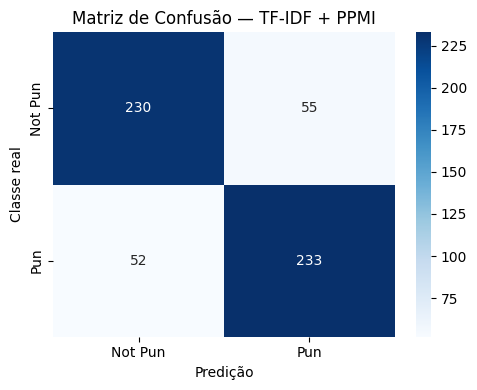

In [78]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_ppmi = confusion_matrix(y_val, y_pred_tuned_ppmi)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_ppmi,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Not Pun", "Pun"],
    yticklabels=["Not Pun", "Pun"]
)

plt.title("Matriz de Confusão — TF-IDF + PPMI")
plt.xlabel("Predição")
plt.ylabel("Classe real")
plt.tight_layout()
plt.show()

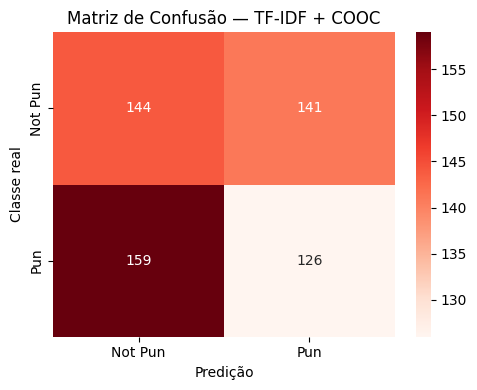

In [79]:
cm_cooc = confusion_matrix(y_val, y_pred_tuned_cooc)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_cooc,
    annot=True,
    fmt="d",
    cmap="Reds",
    xticklabels=["Not Pun", "Pun"],
    yticklabels=["Not Pun", "Pun"]
)

plt.title("Matriz de Confusão — TF-IDF + COOC")
plt.xlabel("Predição")
plt.ylabel("Classe real")
plt.tight_layout()
plt.show()

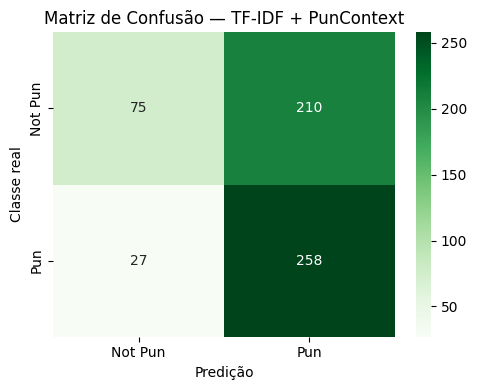

In [80]:
cm_pun = confusion_matrix(y_val, y_pred_tuned_pun)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_pun,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=["Not Pun", "Pun"],
    yticklabels=["Not Pun", "Pun"]
)

plt.title("Matriz de Confusão — TF-IDF + PunContext")
plt.xlabel("Predição")
plt.ylabel("Classe real")
plt.tight_layout()
plt.show()

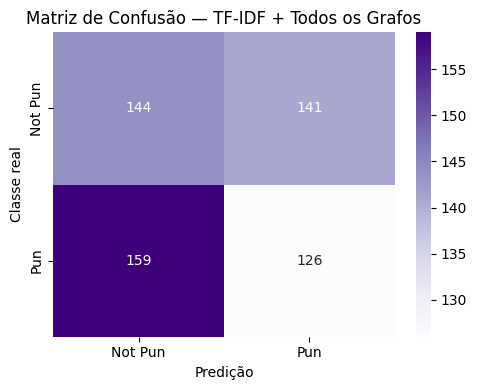

In [81]:
cm_all = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_all,
    annot=True,
    fmt="d",
    cmap="Purples",
    xticklabels=["Not Pun", "Pun"],
    yticklabels=["Not Pun", "Pun"]
)

plt.title("Matriz de Confusão — TF-IDF + Todos os Grafos")
plt.xlabel("Predição")
plt.ylabel("Classe real")
plt.tight_layout()
plt.show()